# Police Response Analysis
## Logan Chang and Robert Yu
## 12/12/20

In this notebook, we examine how police response varies by resistance level faced. We stratify these analysis by race and create charts and output tables along with  some of our own insights. Most of the data covered here was done in the first 'Baseline EDA' notebook, but we add some new analysis here focusing on race and resistance level.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cpd-subjects-with-pb/subjects_with_PB.csv
/kaggle/input/chicago-pd-police-brutality/TRR_FINAL_WITH_PB.csv


Input reading:

In [2]:
#input reading
df_trr = pd.read_csv('/kaggle/input/chicago-pd-police-brutality/TRR_FINAL_WITH_PB.csv')
df_subjects = pd.read_csv('/kaggle/input/cpd-subjects-with-pb/subjects_with_PB.csv')

In [3]:
#just peek at the data we have
df_trr.head()

,trr_id,sr_no,se_no,beat,party_fired_first,taser,firearm_used,trr_year,weapon_discharge_yn,list_of_subcats,...,subject_armed,injured,alleged_injury,subject_no,event_id,race,pb_1,pb_2,max_officer_action,pb_3
0,4,1.0,1.0,1322,NaN,0,0,2004,0,"4.2,",...,0,1,1,1.0,1,HISPANIC,1,1,4.0,1
1,5,1.0,1.0,1322,NaN,0,0,2004,0,"4.2,",...,0,1,1,1.0,1,HISPANIC,1,1,4.0,1
2,7,2.0,2.0,1131,NaN,0,0,2004,1,"4.1,4.2,",...,0,0,0,2.0,2,BLACK,1,0,4.0,1
3,8,2.0,2.0,1131,NaN,0,0,2004,0,"4.2,",...,0,0,0,2.0,2,BLACK,1,0,4.0,1
4,9,3.0,3.0,1112,NaN,0,0,2004,0,"4.2,3.3,",...,0,0,0,3.0,3,BLACK,1,0,4.0,1


In [4]:
#looking at what kind of data we have to work with
df_trr.columns

Index(['trr_id', 'sr_no', 'se_no', 'beat', 'party_fired_first', 'taser',
       'firearm_used', 'trr_year', 'weapon_discharge_yn', 'list_of_subcats',
       'list_of_cats', 'number_of_member_actions', 'number_of_subject_actions',
       'highest_resistance_level', 'list_of_subject_actions',
       'subject_pulled_away', 'subject_disobey_verbal', 'subject_stiffened',
       'subject_fled', 'subject_attack_no_weapon', 'subject_battery_threat',
       'subject_had_weapon', 'subject_attack_with_weapon',
       'subject_deadly_force', 'subject_other', 'subject_armed', 'injured',
       'alleged_injury', 'subject_no', 'event_id', 'race', 'pb_1', 'pb_2',
       'max_officer_action', 'pb_3'],
      dtype='object')

We need to add level of reported police resistance to each subject entry from df_trr to df_subjects:

In [5]:
#adding highest level of resistance for each
def get_res(trr_list, df_trr):
    biggest = -1
    for trr in trr_list:
        trr_entry = df_trr.loc[df_trr['trr_id'] == trr]
#         print(trr_entry['highest_resistance_level'].values)
        try:
            biggest = max(biggest, int(trr_entry['highest_resistance_level'].values))
        except ValueError:
            continue
#         print(biggest)
    return biggest

highest_res_level = {}
for i in range (0, len(df_subjects)):
    trrs = df_subjects['list_of_trr_id'][i]
    trr_list = list(map(int, trrs[:-1].split(",")))
    highest_res_level[i] = get_res(trr_list, df_trr)

In [6]:
#put highest_res_level into df_subjects
df_temp = pd.DataFrame.from_dict(highest_res_level, orient = 'index')
df_temp.columns = ['highest_resistance_level']
df_subjects = pd.concat([df_subjects, df_temp], axis=1)
# new_columns = []
# for column in df_subjects.columns:
#     new_columns.append(column)
# new_columns.append("highest_resistance_level")
# df_subjects.columns = new_columns
df_subjects.head()

,subject_ID,list_of_trr_id,gender,race,age,pb,subcats,age_band,highest_resistance_level
0,1.0,"4,5,",MALE,HISPANIC,38.0,1.0,4.2,30-39,1
1,2.0,"7,8,",MALE,BLACK,25.0,0.0,"4.2, 4.1",20-29,1
2,3.0,"9,",MALE,BLACK,24.0,0.0,"4.2, 3.3",20-29,1
3,4.0,"10,",MALE,BLACK,21.0,0.0,3.3,20-29,0
4,5.0,"11,12,",MALE,BLACK,21.0,1.0,"4.2, 3.3",20-29,0


We did this already in a previous notebook, but let's look at the breakdown of resistance level by race again:

In [7]:
#breakdown of races of all subjects
print('Breakdown of Total Subjects by Race: ')
print(df_subjects.race.value_counts())

Breakdown of Total Subjects by Race: 
BLACK                             30211
HISPANIC                           5653
WHITE                              4065
ASIAN/PACIFIC ISLANDER              292
NATIVE AMERICAN/ALASKAN NATIVE       35
Name: race, dtype: int64


In [8]:
#breakdown of race of subjects at each resitance level
for res_level in sorted(df_subjects.highest_resistance_level.unique()):
    temp = df_subjects.loc[df_subjects.highest_resistance_level == res_level]
    print('Number of Subjects with Resitance Level of '+str(res_level)+' by Race:')
    print(temp.race.value_counts())
    print('-'*55)

Number of Subjects with Resitance Level of -1 by Race:
BLACK    3
WHITE    2
Name: race, dtype: int64
-------------------------------------------------------
Number of Subjects with Resitance Level of 0 by Race:
BLACK                     290
HISPANIC                   69
WHITE                      64
ASIAN/PACIFIC ISLANDER      4
Name: race, dtype: int64
-------------------------------------------------------
Number of Subjects with Resitance Level of 1 by Race:
BLACK                             12948
HISPANIC                           2278
WHITE                              1536
ASIAN/PACIFIC ISLANDER              132
NATIVE AMERICAN/ALASKAN NATIVE       11
Name: race, dtype: int64
-------------------------------------------------------
Number of Subjects with Resitance Level of 2 by Race:
BLACK                             4161
HISPANIC                           797
WHITE                              574
ASIAN/PACIFIC ISLANDER              45
NATIVE AMERICAN/ALASKAN NATIVE       5
Nam

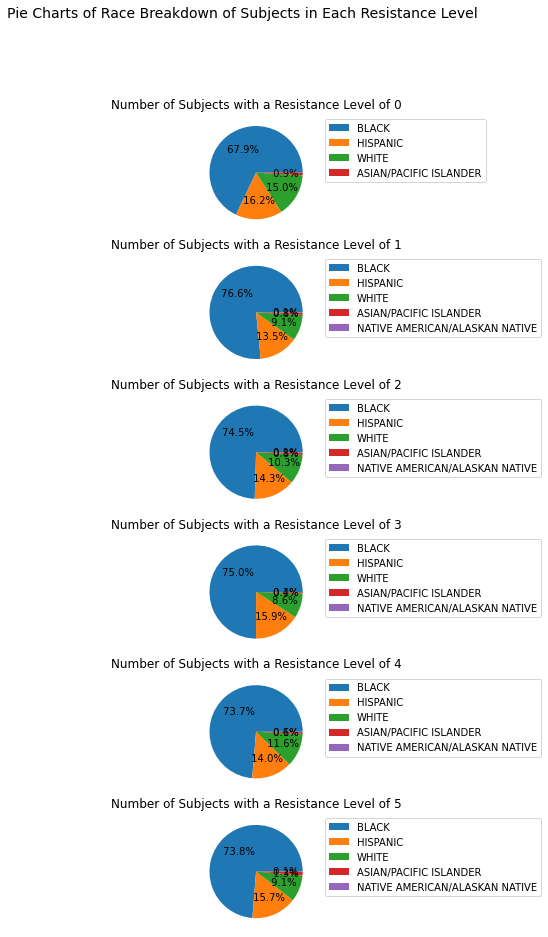

In [9]:
#PIE CHARTS
fig, axs = plt.subplots(6, figsize = (15,15))
fig.suptitle('Pie Charts of Race Breakdown of Subjects in Each Resistance Level', fontsize = 14)
for i in range(0,6):
    axs[i].set_title('Number of Subjects with a Resistance Level of '+str(i))
    data = json.loads(df_subjects.loc[df_subjects.highest_resistance_level == i].race.value_counts().to_json())
    axs[i].pie(data.values(), autopct =' %1.1f%%')
    axs[i].legend(data.keys(), bbox_to_anchor = (1.05,1))
# plt.tight_layout()
plt.show()

Notes on this data:
* -1 resitance means no resistance measured
* Blacks make up the most number of subjects at all levels of resistance. This is not surprising given the sheer volume of Black subjects
* All of the resistance levels follow the same "ranking" of number of subjects by race at each resistance level (Black, Hispanic, White, Asian, Native American)
* The number of black subjects is usually ~4x-8x the number of Hispanic subjects, which is usually ~1.5x the number of White subjects at each resistance level. This matches the differences between the same race groups among total subjects

Now, let's isolate each subject by resistance level and see what happens:

In [10]:
#add a new column that's the maximum level of police force used
max_force = {}
i = 0
def get_max_force(df_subjects):
    global i
    for index, row in df_subjects.iterrows():
        if pd.isnull(row['subcats']):
            max_force[i] = 0.0
        else:
            subcats = list(map(float, row['subcats'].split(", ")))
            max_force[i] = math.floor(max(subcats))
        i += 1
get_max_force(df_subjects)
df_temp = pd.DataFrame.from_dict(max_force, orient = 'index')
df_temp.columns = ['max_force']
df_subjects = pd.concat([df_subjects, df_temp], axis=1)
df_subjects.head()

,subject_ID,list_of_trr_id,gender,race,age,pb,subcats,age_band,highest_resistance_level,max_force
0,1.0,"4,5,",MALE,HISPANIC,38.0,1.0,4.2,30-39,1,4.0
1,2.0,"7,8,",MALE,BLACK,25.0,0.0,"4.2, 4.1",20-29,1,4.0
2,3.0,"9,",MALE,BLACK,24.0,0.0,"4.2, 3.3",20-29,1,4.0
3,4.0,"10,",MALE,BLACK,21.0,0.0,3.3,20-29,0,3.0
4,5.0,"11,12,",MALE,BLACK,21.0,1.0,"4.2, 3.3",20-29,0,4.0


We will now investigate the level of "excessive" force. We beleive "excessive" force to be defined as the level of police force (its integer value) being 2 levels greater than the level of subject resistance or the officer using a firearm and if the subject was injured. This is all encapsulated in the '*pb*' column of the subjects dataframe

***For reference the levels of subject resistance are as follows:***

*Passive Resister = 0*

*Active Resister = 1*

*Assailant Assault = 2*

*Assailant Assault/Battery = 3*

*Assailant Battery = 4*

*Assailant Deadly Force = 5*

***For reference, the levels of police force are as follows***

*2.0: Other Force (the level of forces varies)*

*3.0: Physical Force - Holding, Taser Display*

*4.0: Physical Force - Stunning, Chemical*

*5.0: Impact Weapon, Taser, Physical Force - Direct Mechanical*

*6.0: Firearm*

In [11]:
#get aggreagate totals of police brutality by race
resistances = ['Passive Resistor', 'Active Resistor', 'Assailant Assault', 'Assailant Assault/Battery', 'Assailant Battery', 'Assailant Deadly Force']
print('Number of Subjects Experiencing \'Excessive Force\' at Each Level of Subject Resistance by Race: ')
print('-'*60 + '\n')
for i in range(0,6):
    print('Resistance Level: '+ resistances[i])
    df_res_level = df_subjects[(df_subjects['highest_resistance_level'] == i) & (df_subjects['pb'] == 1)]
    totals = df_res_level.race.value_counts().to_dict()
    totals = dict(sorted(totals.items(), key=lambda item: item[1]))
    for race in reversed(list(totals.keys())):
        print(race + ": "+ str(totals[race]))
    print('-'*50)

Number of Subjects Experiencing 'Excessive Force' at Each Level of Subject Resistance by Race: 
------------------------------------------------------------

Resistance Level: Passive Resistor
BLACK: 52
WHITE: 10
HISPANIC: 10
--------------------------------------------------
Resistance Level: Active Resistor
BLACK: 2388
HISPANIC: 416
WHITE: 299
ASIAN/PACIFIC ISLANDER: 17
NATIVE AMERICAN/ALASKAN NATIVE: 1
--------------------------------------------------
Resistance Level: Assailant Assault
BLACK: 795
HISPANIC: 133
WHITE: 118
ASIAN/PACIFIC ISLANDER: 7
--------------------------------------------------
Resistance Level: Assailant Assault/Battery
BLACK: 396
HISPANIC: 82
WHITE: 44
ASIAN/PACIFIC ISLANDER: 2
--------------------------------------------------
Resistance Level: Assailant Battery
BLACK: 1819
HISPANIC: 341
WHITE: 313
ASIAN/PACIFIC ISLANDER: 15
--------------------------------------------------
Resistance Level: Assailant Deadly Force
BLACK: 213
HISPANIC: 47
WHITE: 28
ASIAN/PACI

Now, let's look at the percentage of citizens at each resistance level experiencing police brutality by race. The purpose of this analysis is to see if police have a bias towards subjects by race. For example, a high percentage means that police show a pattern of being more brutal to suspects of that race more often compared to suspects of other races who show the same level of resistance: 

In [12]:
#helper method to do analysis
def get_excess_force(df):
    percentage_dict = {}
    race_totals = json.loads(df.race.value_counts().to_json())
    df_force = df[(df.pb == 1)]
#     print(df_force.head())
    force_race_totals = json.loads(df_force.race.value_counts().to_json())
    for race in race_totals.keys():
        try:
            percentage_dict[race] = force_race_totals[race]/race_totals[race]*100
        except:
            # -1 placeholder to swap w/ nan
            percentage_dict[race] = -1
    return percentage_dict

In [13]:
#format percentages output nicely 
resistances = ['Passive Resistor', 'Active Resistor', 'Assailant Assault', 'Assailant Assault/Battery', 'Assailant Battery', 'Assailant Deadly Force']
print('Percent of Subjects at Each Level of Subject Resistance Experiencing \'Excessive Force\' by Race: ')
print('-'*60 + '\n')
for i in range(0,6):
    print('Resistance Level: '+ resistances[i])
    df_res_level = df_subjects[(df_subjects['highest_resistance_level'] == i)]
    percentages = get_excess_force(df_res_level)
    percentages = dict(sorted(percentages.items(), key=lambda item: item[1]))
    for race in reversed(list(percentages.keys())):
        if percentages[race] == -1:
            percentages[race] = np.nan
        print(race + ": "+ str(percentages[race]))
    print('-'*50)

Percent of Subjects at Each Level of Subject Resistance Experiencing 'Excessive Force' by Race: 
------------------------------------------------------------

Resistance Level: Passive Resistor
BLACK: 17.93103448275862
WHITE: 15.625
HISPANIC: 14.492753623188406
ASIAN/PACIFIC ISLANDER: nan
--------------------------------------------------
Resistance Level: Active Resistor
WHITE: 19.466145833333336
BLACK: 18.443002780352177
HISPANIC: 18.26163301141352
ASIAN/PACIFIC ISLANDER: 12.878787878787879
NATIVE AMERICAN/ALASKAN NATIVE: 9.090909090909092
--------------------------------------------------
Resistance Level: Assailant Assault
WHITE: 20.557491289198605
BLACK: 19.105984138428262
HISPANIC: 16.68757841907152
ASIAN/PACIFIC ISLANDER: 15.555555555555555
NATIVE AMERICAN/ALASKAN NATIVE: nan
--------------------------------------------------
Resistance Level: Assailant Assault/Battery
BLACK: 18.92021022455805
HISPANIC: 18.426966292134832
WHITE: 18.410041841004183
ASIAN/PACIFIC ISLANDER: 16.6666

Obersvations:
* Among all levels of subject resistance, Black subjects have the most number of subjects experiencing police brutality as we have defined the term. This is often followed by Hispanic subjects having the second most number of subjects experiencing police brutality at each level of subject resistance and then White subjects
* Black subjects also typically experience a much greater amount of brutality at each resistance level, often 6x-8x more than Hispanic subjects of the same resistance level and more than all other racial groups combined at the same level of resistance
* This would tend to point that Blacks are involved in more police confrontations than all other racial groups, despite only making up 30% of Chicago's population and not being the city's most populous racial group. Thus, Black citizens have an increased likelihood of being victims of police brutality simply due to sheer volume 
* Across all levels of subject resistance, the percentages of subjects experiencing police brutality by race had very little variance within each level of resistance. This suggests that all race groups experience around the same rate of police brutality (as we have defined it) at all levels of subject resistance
* In 4 out of the 6 resistance levels, White subjects had the greatest percentage of subjects experencing police brutality with Black subjects always within 2 percenatage points
* These percentages suggest that Chicago police officers perform brutality at equal rates to all subjects of similar resistance, regardless of race. Often, White citizens of each resistance level experience a marginally greater percentage of subjects being victims of police brutality